## Libraries

In [11]:
from __future__ import division
import pandas as pd
import cv2
from helpers import Helper
import numpy as np
import random
import tifffile as tiff
import matplotlib.pyplot as plt
import shapely
import os
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.filters import threshold_isodata, threshold_adaptive, threshold_li, threshold_local, threshold_mean, threshold_minimum, threshold_niblack, threshold_otsu, threshold_sauvola, threshold_triangle, threshold_yen 
from skimage.exposure import equalize_adapthist
from skimage.transform import rescale, resize
import skimage.color as color
import mxnet as mx
from mxnet.io import DataBatch
import random 

def calc_jac(pred, label):
    itersec = np.multiply(pred, label).sum()
    summ = (pred+label).sum()
    jac = itersec/(summ-itersec)
    return jac

def dilation(binary, kernel_type):
    return cv2.dilate(binary , kernel_type, iterations = 5)

def erosion(binary, kernel_type):
    return cv2.erode(binary, kernel_type, iterations = 5)

def ellipse_open(binary, kernel_type): 
    return cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_type)

def best_morphology(binary, label):
    
    # delete noise
    # noise removal
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)
    
#     kernel_size = 5
#     kernel = np.ones((kernel_size, kernel_size),np.uint8)
#     opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # test best morphology
    kernel_size = 3
    kernel_type = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size, kernel_size)) 
    
    jac_d = calc_jac(opening, label)
    jac_e = calc_jac(erosion(opening, kernel_type), label)
    jac_ellipse_open = calc_jac(ellipse_open(opening, kernel_type), label)
    
    morph = [dilation, erosion, ellipse_open]
    ind = np.argmax([jac_d, jac_e, jac_ellipse_open])
    return morph[ind], kernel_type

def normalize(bands):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    print bands.shape
    for i in range(n):
        out[:, :, i] = equalize_adapthist((bands[:,:,i]).astype(np.float32))

    return out.astype(np.float32)

def stretch_n(bands, lower_percent=0, higher_percent=100):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]

    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


# 0-coastal 1
# 1-blue 2
# 2-green 3
# 3-yellow 4
# 4-red 5 
# 5-red edge 6
# 6-near-IR1 7
# 7-near-IR2 8

## Data Loading

In [13]:
data = pd.read_csv('../data/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = '../data/grid_sizes.csv'
wkt_fname = '../data/train_wkt_v4.csv'
image_fname = '../data/sixteen_band/'

In [14]:
data.ClassType.value_counts()

5     25
4     23
2     17
6     14
10    13
8     13
1     12
3     11
9      8
7      2
Name: ClassType, dtype: int64

In [15]:
print sorted(data[data.ClassType==5].ImageId.unique())

['6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2', '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2', '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4', '6170_4_1']


In [18]:
# upload model 

helper = Helper()

In [22]:
IM_ID = sorted(data[data.ClassType==5].ImageId.unique())[0]

# read rgb channels and mask
rgb, mask = helper.load_im_polymask(IM_ID, '5', '../data/three_band/', '../data/train_wkt_v4.csv', '../data/grid_sizes.csv')

# read m band
m = tiff.imread('../data/train/{}_M.tif'.format(IM_ID))

shape_0 = 3345
shape_1 = 3338

# rgb
blue = cv2.resize(m[1, :, :], (shape_1, shape_0), interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]
green = cv2.resize(m[2, :, :], (shape_1, shape_0), interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]
red = cv2.resize(m[4, :, :], (shape_1, shape_0), interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]

# nir1 = cv2.resize(m[6, :, :], (shape_1, shape_0), interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]
# nir2 = cv2.resize(m[7, :, :], (shape_1, shape_0), interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]

image = np.concatenate([red, green, blue], axis=2)
img_rgb_norm = (image - np.array([ 426.98400879, 464.88424683, 329.17596436]))

 # swapaxes
img_rgb_norm = img_rgb_norm
img_rgb_norm = np.swapaxes(img_rgb_norm, 0, 2)
img_rgb_norm = np.swapaxes(img_rgb_norm, 1, 2)
img_rgb_norm = img_rgb_norm[np.newaxis, :]

# random crop
crop_size = 400
rand = random.Random()

crop_max_x = img_rgb_norm.shape[3] - crop_size
crop_max_y = img_rgb_norm.shape[2] - crop_size

crop_x = rand.randint(0, crop_max_x)
crop_y = rand.randint(0, crop_max_y)

img_crop = img_rgb_norm[:, :, crop_y:crop_y + crop_size, crop_x: crop_x + crop_size]
mask_croped = mask[crop_y:crop_y + crop_size, crop_x: crop_x + crop_size]
mask_croped = np.expand_dims(mask_croped, axis=0)
mask_croped = np.expand_dims(mask_croped, axis=0)


In [66]:
predictor = mx.module.Module.load(prefix='../unet', epoch=100, context=mx.gpu(0), label_names=None)
# predictor.bind(data_shapes=[('data', (1,3,400,400))], label_shapes=None, for_training=False)

In [67]:
predictor.

['_mulscalar0_output']

In [59]:
nd_iter = mx.io.NDArrayIter(mx.nd.array(img_crop), batch_size=1)
predictor.forward(img_crop)

AssertionError: 

In [36]:
m.shape

(8, 837, 849)

In [41]:
m.swapaxes(0,2).swap.shape

(849, 837, 8)

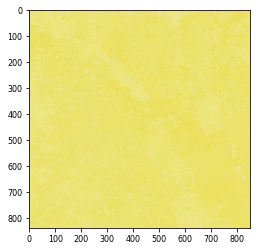

In [47]:
plt.imshow(m.swapaxes(0,2).swapaxes(0,1)[:,:,1:4])

In [5]:
helper = Helper()
pr_size = 512

for IM_ID in data[data.ClassType == 4].ImageId.values:
    print IM_ID
    
    rgb, mask = helper.load_im_polymask(IM_ID, '5', image_fname, wkt_fname, grid_sizes_fname)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    NIR=resize(m[6,:,:], (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis] 
    NIR2=resize(m[7,:,:], (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    B=resize(m[1,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    G=resize(m[2,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    R=resize(m[4,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    C=resize(m[0,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    Y=resize(m[3,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    RE=resize(m[5,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    
    bands = np.concatenate([C, B, G, Y,R, RE, NIR, NIR2], axis=2)
    rgb = bands
    counter = 0
    
    for i in range(0,6):    
        for j in range(0,6):
            crop = rgb[i*pr_size:i*pr_size+pr_size, j*pr_size:j*pr_size+pr_size, :]
            msk = mask[i*pr_size:i*pr_size+pr_size, j*pr_size:j*pr_size+pr_size]
            
            tiff.imsave('data/train/A/{}.tif'.format(IM_ID+str(i)+str(j)), crop)
            tiff.imsave('data/train/B/{}.tif'.format(IM_ID+str(i)+str(j)), msk)
            counter+=1
            
        crop = rgb[i*pr_size:i*pr_size+pr_size, -pr_size:, :]
        msk = mask[i*pr_size:i*pr_size+pr_size, -pr_size:]
        
        tiff.imsave('data/train/A/{}.tif'.format(IM_ID+str(i)+str(j)+'right'), crop)
        tiff.imsave('data/train/B/{}.tif'.format(IM_ID+str(i)+str(j)+'right'), msk)
        counter+=1
        
        # predictions for bottom part 
        if i==5:
            for j in range(0,6):
                crop = rgb[-pr_size:, j*pr_size:j*pr_size+pr_size, :]
                msk= mask[-pr_size:, j*pr_size:j*pr_size+pr_size]
                
                tiff.imsave('data/train/A/{}.tif'.format(IM_ID+str(i+1)+str(j)), crop)
                tiff.imsave('data/train/B/{}.tif'.format(IM_ID+str(i+1)+str(j)), msk)
                counter+=1
                
            crop = rgb[-pr_size:, -pr_size:, :]
            msk = mask[-pr_size:, -pr_size:]
            
            tiff.imsave('data/train/A/{}.tif'.format(IM_ID+str(i+1)+str(j+1)), crop)
            tiff.imsave('data/train/B/{}.tif'.format(IM_ID+str(i+1)+str(j+1)), msk)
            counter+=1
    print counter

6040_2_2


/home/home/scikit-image/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


49
6120_2_2
49
6120_2_0
49
6090_2_0
49
6040_1_3
49
6040_1_0
49
6100_1_3
49
6010_4_2
49
6110_4_0
49
6140_3_1
49
6110_1_2
49
6100_2_3
49
6150_2_3
49
6160_2_1
49
6140_1_2
49
6110_3_1
49
6170_2_4
49
6170_4_1
49
6170_0_4
49
6060_2_3
49
6010_1_2
49
6040_4_4
49
6100_2_2
49


In [ ]:
helper = Helper()
for IM_ID in data[data.ClassType == 4].ImageId.values:
    rgb, mask = helper.load_im_polymask(IM_ID, '4', image_fname, wkt_fname, grid_sizes_fname)
    
    plt.imshow(stretch_n(rgb, lower_percent=2, higher_percent=98))
    plt.show()
    
    plt.imshow(mask)
    plt.show()

In [ ]:
helper = Helper()
pr_size = 512

for IM_ID in data[data.ClassType == 4].ImageId.values[-1:]:
    print IM_ID
    rgb, mask = helper.load_im_polymask(IM_ID, '4', image_fname, wkt_fname, grid_sizes_fname)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    NIR = resize(m[6,:,:], (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis] 
    NIR2 = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    B = resize(m[1,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    G = resize(m[2,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    R = resize(m[4,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    C = resize(m[0,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    Y = resize(m[3,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    RE = resize(m[5,:,:],   (rgb.shape[0], rgb.shape[1]))[:,:, np.newaxis]
    
    bands = np.concatenate([C, B, G, Y,R, RE, NIR, NIR2], axis=2)
    rgb=bands
    counter = 0
    
    for i in range(0,6):    
        for j in range(0,6):
            crop = rgb[i*pr_size:i*pr_size+pr_size, j*pr_size:j*pr_size+pr_size, :]
            msk = mask[i*pr_size:i*pr_size+pr_size, j*pr_size:j*pr_size+pr_size]
            
            tiff.imsave('data/val/A/{}.tif'.format(IM_ID+str(i)+str(j)), crop)
            tiff.imsave('data/val/B/{}.tif'.format(IM_ID+str(i)+str(j)), msk)
            counter+=1
            
        crop = rgb[i*pr_size:i*pr_size+pr_size, -pr_size:, :]
        msk = mask[i*pr_size:i*pr_size+pr_size, -pr_size:]
        
        tiff.imsave('data/val/A/{}.tif'.format(IM_ID+str(i)+str(j)+'right'), crop)
        tiff.imsave('data/val/B/{}.tif'.format(IM_ID+str(i)+str(j)+'right'), msk)
        counter+=1
        
        # predictions for bottom part 
        if i==5:
            for j in range(0,6):
                crop = rgb[-pr_size:, j*pr_size:j*pr_size+pr_size, :]
                msk= mask[-pr_size:, j*pr_size:j*pr_size+pr_size]
                
                tiff.imsave('data/val/A/{}.tif'.format(IM_ID+str(i+1)+str(j)), crop)
                tiff.imsave('data/val/B/{}.tif'.format(IM_ID+str(i+1)+str(j)), msk)
                counter+=1
                
            crop = rgb[-pr_size:, -pr_size:, :]
            msk = mask[-pr_size:, -pr_size:]
            
            tiff.imsave('data/val/A/{}.tif'.format(IM_ID+str(i+1)+str(j+1)), crop)
            tiff.imsave('data/val/B/{}.tif'.format(IM_ID+str(i+1)+str(j+1)), msk)
            counter+=1
    print counter

In [14]:
waterway = pd.read_csv('../submits/0.9528_waterway_index.csv')
sw = pd.read_csv('../submits/0.3137_standing_water_index.csv')
road = pd.read_csv('../submits/0.37_road_pix2pix.csv')
trees = pd.read_csv('../submits/0.4722_trees_pix2pix.csv')
build = pd.read_csv('../submits/0.602_buildings_pix2pix.csv')
crops = pd.read_csv('../submits/0.6929_crops_pix2pix.csv')
manmade = pd.read_csv('../submits/manmade_p2p_final.csv')

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('../input/sample_submission.csv')

In [17]:
counter = 1 
for idx, row in df.iterrows():
    _id = row[0]
    kls = row[1]
    
    if kls == 1:
        df.iloc[idx, 2] = build[(build.ClassType==kls) & (build.ImageId==_id)].MultipolygonWKT.values[0]
        
    if kls == 2:
        df.iloc[idx, 2] = manmade[(manmade.ClassType==kls) & (manmade.ImageId==_id)].MultipolygonWKT.values[0]
    
    if kls == 3:
        df.iloc[idx, 2] = road[(road.ClassType==kls) & (road.ImageId==_id)].MultipolygonWKT.values[0]
    
    if kls == 5:
        df.iloc[idx, 2] = trees[(trees.ClassType==kls) & (trees.ImageId==_id)].MultipolygonWKT.values[0]
    
    if kls == 6:
        df.iloc[idx, 2] = crops[(crops.ClassType==kls) & (crops.ImageId==_id)].MultipolygonWKT.values[0]
    
    if kls == 7:
        df.iloc[idx, 2] = waterway[(waterway.ClassType==kls) & (waterway.ImageId==_id)].MultipolygonWKT.values[0]
    
    if kls == 8:
        df.iloc[idx, 2] = sw[(sw.ClassType==kls) & (sw.ImageId==_id)].MultipolygonWKT.values[0]
        
    print counter
    counter += 1

print df.head()
df.to_csv('final_submit2.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
